In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.neighbors import KNeighborsClassifier
def generate_data_matrix(mainPath):
    label = 1
    data = []
    labels = []
    directories = os.listdir(path=mainPath)
    for directory in directories:
        path = os.path.join(mainPath,directory)
        files = os.listdir(path=path)
        for file in files:
            file_path=os.path.join(path,file)
            img = np.array(convert_pgm(file_path))
            img=img.flatten()
            data.append(img)
            labels.append(label)
        label+=1
    return [data,labels]
    
def convert_pgm(pgm_file_path):
    f=open(pgm_file_path,'rb')
    for l in range(3):
        f.readline()
    img = []
    for i in range(112):
        row = []
        for i in range(92):
            row.append(ord(f.read(1)))
        img.append(row)
    return img


        

data, labels = generate_data_matrix("archive")
data = np.array(data)
labels = np.array(labels)
labels = labels.reshape(400,1)





In [2]:
X_train = data[::2, :] #odd rows for training set
Y_train = labels[::2, :].reshape(200,)
X_test = data[1::2,:] #even row for test set
Y_test = labels[1::2, :].reshape(200,)


# PCA 

In [120]:
def PCA(X_train, alpha):
    mean = np.mean(X_train, axis = 0) #Computing Mean
    Z_train = X_train - mean # Centering the data
    #centering test set
    Z_test=X_test-mean
    cov = (1/400) * np.dot(Z_train.T, Z_train)
    eigen_values, eigen_vectors = np.linalg.eigh(cov)
    #sorting eigen values
    idx=np.argsort(eigen_values)[::-1]
    eigen_values=eigen_values[idx]
    eigen_vectors=eigen_vectors[:,idx]
    #Y_train = Y_train.reshape(200,)
    #Y_test = Y_test.reshape(200,)
    #alphas = [0.8, 0.85, 0.9, 0.95,1,1.5,2,2.5,3,3.5,4]
    sum_eigen_values = sum(eigen_values)
    for i in range(len(eigen_values)):
        var=sum(eigen_values[0:i+1:])/sum_eigen_values
        if var >= alpha:
            print("for alpha = " + str(alpha) + " explained variance = " + str(var))
            break
        else:
            continue
    P = eigen_vectors[:,:i+1] # Projection Matrix
    return [P, var, Z_train, Z_test] # Return projection matrix and explained variance.

In [12]:
def knn(X_train,Y_train,X_test,Y_test, k):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train.T, Y_train)
    accuracy = knn.score(X_test.T, Y_test)
    return accuracy

In [122]:
# #sorting eigen values
# idx=np.argsort(eigen_values)[::-1]
# eigen_values=eigen_values[idx]
# eigen_vectors=eigen_vectors[:,idx]
# Y_train = Y_train.reshape(200,)
# Y_test = Y_test.reshape(200,)
# alphas = [0.8, 0.85, 0.9, 0.95,1,1.5,2,2.5,3,3.5,4]

(10304, 10304)
for alpha = 0.8 explained variance = 0.8016311012351774
At alpha = 0.8, The mean accuracy = 0.94
(10304, 10304)
for alpha = 0.85 explained variance = 0.8524299364897455
At alpha = 0.85, The mean accuracy = 0.94
(10304, 10304)
for alpha = 0.9 explained variance = 0.9011500964818602
At alpha = 0.9, The mean accuracy = 0.94
(10304, 10304)
for alpha = 0.95 explained variance = 0.9502436919094086
At alpha = 0.95, The mean accuracy = 0.93


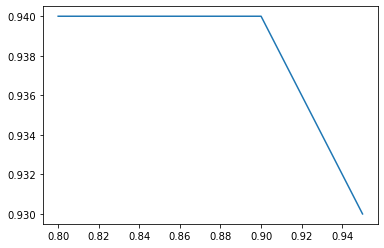

In [123]:
#sum_eigen_values = sum(eigen_values)
alphas = [0.8, 0.85, 0.9, 0.95]
accuracy_for_each_alpha = []
for alpha in alphas:
#    for i in range(len(eigen_values)):
#         var=sum(eigen_values[0:i+1:])/sum_eigen_values
#         if var >= alpha:
#             print("for alpha = " + str(alpha) + " explained variance = " + str(var))
#             break
#         else:
#             continue
#     P=eigen_vectors[:,:i+1]
    P, var, Z_train, Z_test = PCA(X_train, alpha)
    projected_Z_train = np.dot(P.T, Z_train.T)
    projected_Z_test = np.dot(P.T, Z_test.T)
    accuracy = knn(projected_Z_train,Y_train, projected_Z_test, Y_test,1)
#     knn = KNeighborsClassifier(n_neighbors=1)
#     knn.fit(projected_Z_train.T, Y_train)
    #accuracy = knn.score(projected_Z_test.T, Y_test)
    accuracy_for_each_alpha.append(accuracy)
    print("At alpha = " + str(alpha) + ", The mean accuracy = " + str(accuracy))
    

plt.plot(alphas, accuracy_for_each_alpha)
    
    
    

    
        


In [7]:
k_list = [3, 5, 7]
alpha_K = np.zeros((4,3)) #2-D array showing accuracy for each combination of alpha and K
for i in range(len(alphas)):
    P2, var2, Z_train2, Z_test2 = PCA(X_train, alphas[i])
    projected_Z_train2 = np.dot(P2.T, Z_train2.T)
    projected_Z_test2 = np.dot(P2.T, Z_test2.T)
    for j in range(len(k_list)):
        alpha_K[i][j]= knn(projected_Z_train2,Y_train, projected_Z_test2, Y_test,k_list[j]) 
        
print(alpha_K)

for alpha = 0.8 explained variance = 0.8016311012351774
for alpha = 0.85 explained variance = 0.8524299364897455
for alpha = 0.9 explained variance = 0.9011500964818602
for alpha = 0.95 explained variance = 0.9502436919094086
[[0.875 0.825 0.775]
 [0.87  0.83  0.76 ]
 [0.875 0.81  0.74 ]
 [0.865 0.79  0.715]]


# LDA

In [3]:
def between_class_scatter(X_train):
    means= np.ones((40,10304))
    #calculating mean of each class
    index=0
    for i in range(0,200,5):
        means[index]=np.mean(X_train[i:i+5],axis=0,keepdims=True)
        index+=1
     #overall mean
    ov_mean=np.mean(X_train,axis=0,keepdims=True)
    Sb=np.zeros((10304,10304))
    #between class scatter
    for i in range(40):
        m=means[i]-ov_mean
        m=m.reshape(10304,1)
        Sb=np.add(Sb,5*np.dot(m,m.T))
    return [means,Sb]

In [7]:
def within_class_scatter(X_train,means):
    #overall mean
    ov_mean=np.mean(X_train,axis=0,keepdims=True)
    S=np.zeros((10304,10304))
    #within class scatter
    index=0
    for i in range(0,200,5):
        class_scatter=X_train[i:i+5]-means[index]
        class_scatter=class_scatter.reshape(5,10304)
        index+=1
        S=np.add(S,np.dot(class_scatter.T,class_scatter))
    return S

In [8]:
def LDA(S,Sb):
    transformation_matrix=np.dot(np.linalg.inv(S),Sb)
    eigen_values,eigen_vectors=np.linalg.eigh(transformation_matrix)
    #sorting eigen values
    idx=np.argsort(eigen_values)[::-1]
    eigen_values=eigen_values[idx]
    eigen_vectors=eigen_vectors[:,idx]
    U=eigen_vectors[:,:39]
    return U
    

In [10]:
means,Sb=between_class_scatter(X_train)
S=within_class_scatter(X_train,means)
U=LDA(S,Sb)





In [13]:
# Centering the data
Z_train = X_train - np.mean(X_train, axis = 0) 
#centering test set
Z_test=X_test-np.mean(X_train, axis = 0)
#projecting training and test sets on U
Train_projected=np.dot(U.T,Z_train.T)
Test_projected=np.dot(U.T,Z_test.T)
#KNN
accuracy_LDA = knn(Train_projected,Y_train, Test_projected, Y_test,1)
print(U)


[[-0.0010907   0.0098262  -0.00318217 ...  0.00320958 -0.01806492
   0.00207979]
 [-0.0010124   0.00900439 -0.00325589 ...  0.00116154 -0.01821399
   0.00107265]
 [-0.00094497  0.00938537 -0.00296763 ...  0.00173206 -0.02159316
   0.00254041]
 ...
 [ 0.002357   -0.00431373  0.00560766 ...  0.00754592 -0.01033571
   0.00751189]
 [ 0.00344083  0.00323828  0.00124705 ... -0.01093406 -0.00280061
  -0.00667877]
 [-0.00564313 -0.0227092   0.00627021 ... -0.0119644  -0.00966897
   0.0443218 ]]


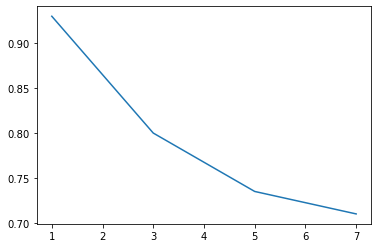

In [140]:
#classifier tuning
k_list = [1, 3, 5, 7]
k_accuracies=[]
for k in k_list:
    k_accuracies.append(knn(Train_projected,Y_train, Test_projected, Y_test,k))
plt.plot(k_list, k_accuracies)
